In [29]:
# Descomentar para actualizar librerias
# Si se actualiza alguna libreria hay que reiniciar el notebook
!pip install plotly --upgrade --user --quiet
!pip install pandas --upgrade --user --quiet
!pip install numpy --upgrade --user --quiet
!pip install scipy --upgrade --user --quiet
!pip install statsmodels --upgrade --user --quiet
!pip install scikit-learn --upgrade --user --quiet
!pip install missingno --upgrade --user --quiet
!pip install apafib --upgrade --user --quiet

In [30]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from time import time
from datetime import timedelta
init_time = time()

# APA - Ejercicio 1 - ¿Qué edad tienes?

## Load Inicial

En este problema trabajaré con el conjunto de datos Stroke Prediction Dataset, el cual contiene una descripcion de un conjunto de personas a partir de características demográficas, médicas y de hábitos. Esto será utilizado para predecir diferentes hechos a partir de este conjunto, principalmente la edad de las personas a partir de sus características personales.

La selección de este conjunto la obtendré utilizando la funcion load_stroke de la libreria apafib.

También cargaremos todos los imports necesarios para hacer todo el estudio y trabajo sobre nuestros datos.

In [31]:
from sklearn import datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix


from sklearn import set_config

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings

from mpl_toolkits.mplot3d import Axes3D

#from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)


set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)



In [38]:
from apafib import load_stroke
spd = load_stroke()

#hacemos un head para ver un poco como es el formato de la tabla inicialmente
spd.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1,33879,Male,42.0,0,0,Yes,Private,Rural,83.41,25.4,Unknown,1
2,14248,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked,1
3,62602,Female,49.0,0,0,Yes,Private,Urban,60.91,29.9,never smoked,1
4,36338,Female,39.0,1,0,Yes,Private,Rural,58.09,39.2,smokes,1


## Apartado A

### Eliminar variables sin sentido

Una vez cargado hemos de eliminar las variables que no tiene sentido utilizar por aportar poco valor al objetivo de nuestro estudio, a priori no podriamos discernir entre claros elementos que no aporten mucho al resultado final más allá de evidentemente el id el cual no nos aporta nada sobre la informacion del individuo al que nos referimos.

El genero tampoco parece aportar demasiado a discernir en la edad de un individuo (tal vez si quisieramos ver probabilidad de otros aspectos de salud si pero en este caso no aporta nada).

Existen variables de estilo de vida que pueden parecer poco relevantes como el tipo de trabajo o tipo de residencia pero puesto que estas pueden estar relacionas con la edad a priori las mantendré.

Tras eliminar las que de momento se consideran poco relevante comodamente queda nuestra variable objetivo como la primera columna.

In [39]:
spd.drop(columns=['id', 'gender'], inplace=True)

Ahora procedo a dividir el conjunto de datos en entrenamiento y test con ratio de (70%/30%).

In [40]:
spd_train, spd_test = train_test_split(spd, test_size=0.3, random_state=0)

spd_train.shape, spd_test.shape

((1972, 10), (846, 10))

Observaremos rápidamente un poco las variables del conjunto de entrenamiento mediante visualizacion para familiarizarnos con la distribución de las mismas.

Nos centraremos en observar la relaciond e variables con la variable objetivo, asimismo mirando de sacar alguna observacion que pueda resultar de interes para las posteriores fases del proyecto.

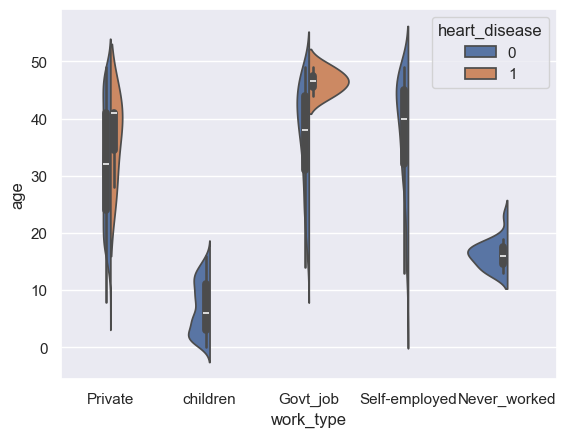

In [46]:
sns.violinplot(data=spd_train,x="work_type", y="age", hue="heart_disease", split=True);

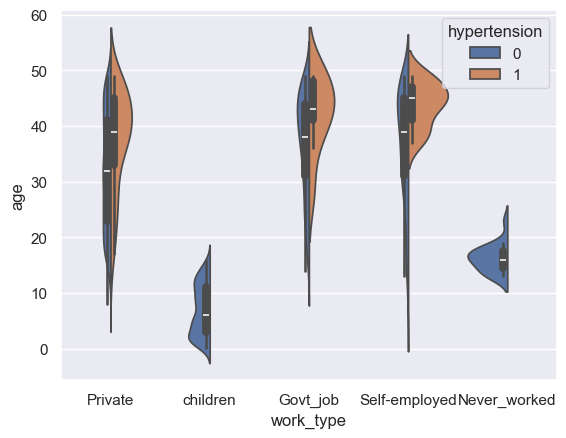

In [45]:
sns.violinplot(data=spd_train, x="work_type",y="age", hue="hypertension", split=True);

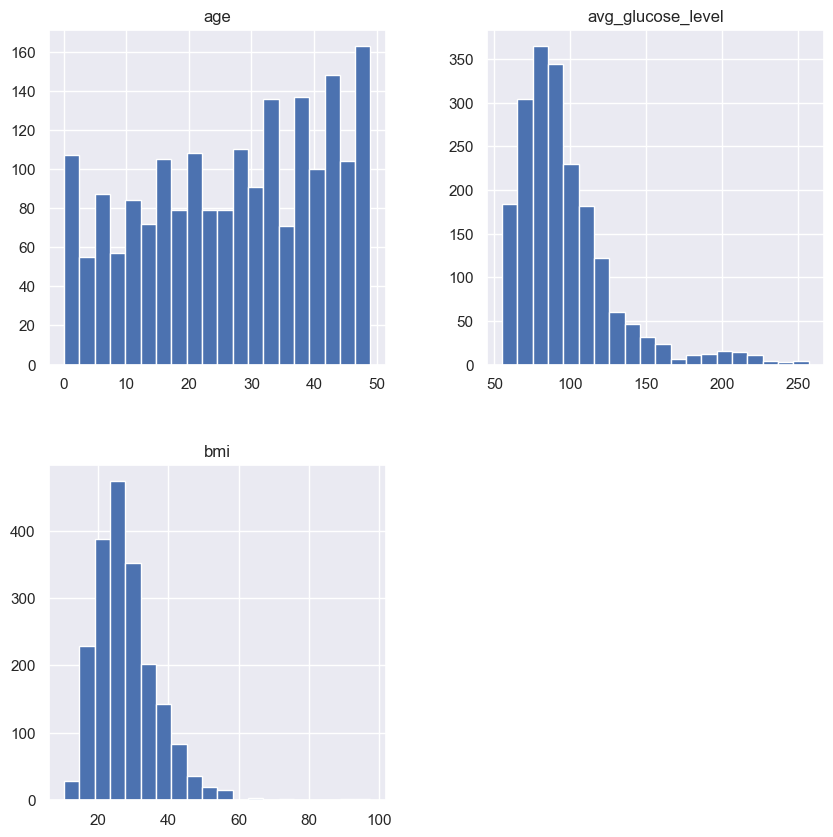

In [42]:
spd_train.loc[:,['age', 'avg_glucose_level', 'bmi']].hist(bins=20, figsize=(10,10));

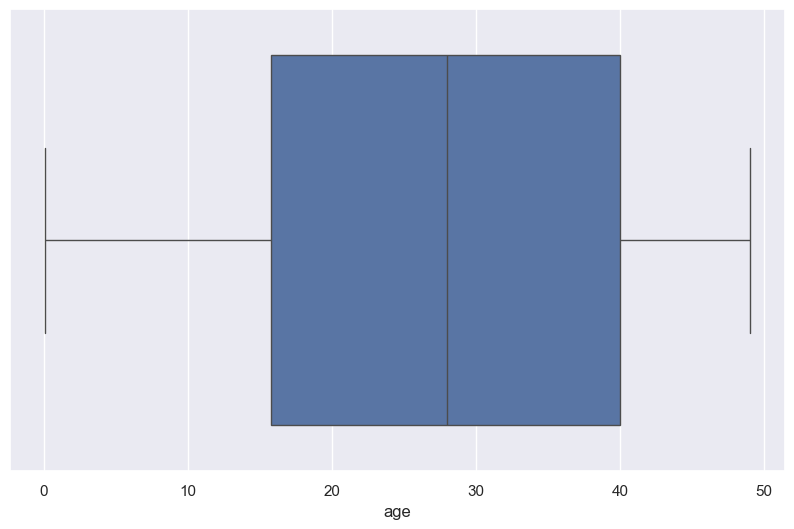

In [43]:
plt.figure(figsize=(10,6));
sns.boxplot(data=spd_train, x="age");

In [28]:
spd_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,846.0,NaN,NaN,NaN,26.047,14.411,0.24,14.0,27.0,39.0,49.0
hypertension,846.0,NaN,NaN,NaN,0.022,0.148,0.0,0.0,0.0,0.0,1.0
heart_disease,846.0,NaN,NaN,NaN,0.006,0.077,0.0,0.0,0.0,0.0,1.0
ever_married,846,2,No,469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,846,5,Private,485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,846,2,Urban,431,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,846.0,NaN,NaN,NaN,96.288,32.809,55.25,75.855,89.23,107.453,267.76
bmi,846.0,NaN,NaN,NaN,26.968,7.983,13.3,21.2,25.5,31.675,78.0
smoking_status,846,4,Unknown,336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stroke,846.0,NaN,NaN,NaN,0.008,0.091,0.0,0.0,0.0,0.0,1.0
